In [113]:
import tensorflow as tf
from tokenization_bert import BertTokenizer
from modeling_tf_bert import TFBertForSequenceClassification

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
import numpy as np
import re

In [107]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [2]:
# Load dataset, tokenizer, model from pretrained model/vocabulary
bert_checkpoint_path = "larva-kor-plus-base-cased-pytorch/"
tokenizer = BertTokenizer.from_pretrained(bert_checkpoint_path)
model = TFBertForSequenceClassification.from_pretrained(bert_checkpoint_path, from_pt=True)

In [108]:
BATCH_SIZE = 16
NUM_EPOCHS = 2
VALID_SPLIT = 0.2
MAX_LEN = 50
DATA_OUT_PATH = "data_out/"
model_name = "tf2_bert"

In [27]:
# Special Tokens
print(tokenizer.all_special_tokens, "\n", tokenizer.all_special_ids)

# Test Tokenizers
print(tokenizer.encode("안녕하세요, 제 이름은 하이 둘")) #한글 인코딩이 잘 안되는 현상 발생
print(tokenizer.encode_plus("hello world"))  #영어 인코딩은 잘 됨 + 버트에 필요한 임베이까지 추가
# print(tokenizer.convert_tokens_to_ids("안녕하세요"))
print(tokenizer.decode( [31998, 31997, 2, 31997, 31997, 31997, 31997, 31999]))

['[UNK]', '[CLS]', '[PAD]', '[MASK]', '[SEP]'] 
 [31997, 31998, 0, 32000, 31999]
[31998, 31997, 2, 31997, 31997, 31997, 31997, 31999]
{'input_ids': [31998, 19902, 1037, 15984, 31999], 'token_type_ids': [0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1]}
[CLS] [UNK], [UNK] [UNK] [UNK] [UNK] [SEP]


In [61]:
# 데이터 전처리 준비

DATA_PATH = '/Users/user/github/tensorflow-ml-nlp-tf2/4.TEXT_CLASSIFICATION/data_in/'
DATA_TRAIN_PATH = DATA_PATH + "ratings_train.txt"
DATA_TEST_PATH = DATA_PATH + "ratings_test.txt"

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [118]:
# 텍스트 전처리

def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", sent)
    return sent_clean

In [102]:
train_data = train_data[:1000] # for test

train_data_sent = [tokenizer.encode(clean_test(train_sent)) for train_sent in train_data["document"]] #문장 토크나이징 리스트 
train_data_sent_pad = np.asarray(pad_sequences(train_data_sent, maxlen=MAX_LEN), dtype=np.int32) # convert into numpy
train_data_label = np.asarray(train_data["label"], dtype=np.int32) #레이블 토크나이징 리스트

In [68]:
# 학습 준비하기
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [70]:
# model.save_pretrained("bert_checkpoint/") # 모델 프리트레인 저장하기
model.summary() #모델 파라메터 수 체크

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110618112 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 110,619,650
Trainable params: 110,619,650
Non-trainable params: 0
_________________________________________________________________


In [128]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = model.fit(train_data_sent_pad, train_data_label, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback],
                   steps_per_epoch=5, validation_steps=2)

print(history.history)

data_out/tf2_bert -- Folder already exists 

Train on 800 samples, validate on 200 samples
Epoch 1/2
 80/800 [==>...........................] - ETA: 2:09 - loss: 0.6873 - accuracy: 0.5375
Epoch 00001: val_accuracy improved from -inf to 0.50000, saving model to data_out/tf2_bert/weights.01-0.50.h5
 80/800 [==>...........................] - ETA: 2:05 - loss: 0.6926 - accuracy: 0.4500
Epoch 00002: val_accuracy did not improve from 0.50000
 80/800 [==>...........................] - ETA: 2:22 - loss: 0.6926 - accuracy: 0.4500 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00

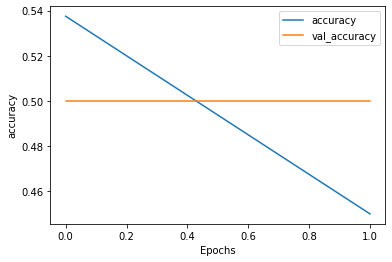

In [129]:
plot_graphs(history, 'accuracy')

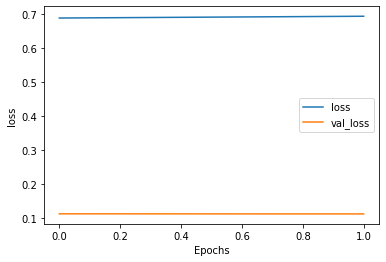

In [130]:
plot_graphs(history, 'loss')

# Test 데이터

In [121]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [125]:
test_data = test_data[:1000] # for test

test_data_sent = [tokenizer.encode(clean_text(test_sent)) for test_sent in test_data["document"]] #문장 토크나이징 리스트 
test_data_sent_pad = np.asarray(pad_sequences(test_data_sent, maxlen=MAX_LEN), dtype=np.int32) # convert into numpy
test_data_label = np.asarray(test_data["label"], dtype=np.int32) #레이블 토크나이징 리스트

In [134]:
results = model.evaluate(test_data_sent_pad, test_data_label)
print("test loss, test acc: ", results)

1000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================